In [1]:
import tensorflow as tf
import keras
import numpy as np
import os
# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
import seaborn as sns

import scipy.stats as sc_stats

import random

from sklearn.model_selection import train_test_split
onehot_encoder=OneHotEncoder(sparse=False)

from tensorflow.contrib import rnn

os.environ['KMP_DUPLICATE_LIB_OK']='True'




from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.models import load_model
from tensorflow.python.keras.metrics import Metric



Using TensorFlow backend.


In [115]:
# Data Dimension
inputs = 4        # number of input features
timesteps = 29         # Timesteps
outputs= 1         # Number of outputs


In [24]:
def add_releveant_features(task_df):


    task_df['PrevOutcome']=task_df['Outcome'].shift(1)
    task_df.loc[1,'PrevOutcome']= 0

    task_df['PrevChoice']=task_df['Choice'].shift(1)
    task_df.loc[1,'PrevChoice']= 0

    task_df['PrevSafe']=task_df['Safe'].shift(1)
    task_df.loc[1,'PrevSafe']= 0

    task_df['PrevBigRisky']=task_df['BigRisky'].shift(1)
    task_df.loc[1,'PrevBigRisky']= 0

    task_df['PrevSmallRisky']=task_df['SmallRisky'].shift(1)
    task_df.loc[1,'PrevSmallRisky']= 0
    
#     task_df['PrevRT']=task_df['RT'].shift(1)
#     task_df.loc[1,'PrevRT']= 0
    
    
    
    return task_df

In [25]:
def add_kback_features(task_df):

    for k in range(1,11):
        task_df[str(k)+'backOutcome']=task_df['Outcome'].shift(k)
        task_df[str(k)+'backChoice']=task_df['Choice'].shift(k)
        task_df[str(k)+'backSafe']=task_df['Safe'].shift(k)
        task_df[str(k)+'backBigRisky']=task_df['BigRisky'].shift(k)
        task_df[str(k)+'backSmallRisky']=task_df['SmallRisky'].shift(k)

    return task_df

In [26]:


dir_list = os.listdir("/Users/ritwik7/Dropbox (Personal)/Postdoc_UCL/DATA/rlab_incomplete_rewardSWB_code/by_RN/appdata/")
dir_path ="/Users/ritwik7/Dropbox (Personal)/Postdoc_UCL/DATA/rlab_incomplete_rewardSWB_code/by_RN/appdata/"

subj_files_list =[]; ## list of subject_files fullfilling a criteria

dir_files = [i for i in os.listdir(dir_path) if i.startswith('sub')]

for subj_file_path in dir_files:

    file_path  ="/Users/ritwik7/Dropbox (Personal)/Postdoc_UCL/DATA/rlab_incomplete_rewardSWB_code/by_RN/appdata/"+ subj_file_path
    mypath =file_path
    
    play_names = [i for i in os.listdir(mypath) if os.path.isfile(os.path.join(mypath,i)) and i.startswith('app')]   
    
    if len(play_names) >= 50: ## criteria
        subj_files_list.append(subj_file_path)
        
    

In [27]:
def compose_data(train_data_df,test_data_df,val_data_df):
    
    train_new_data_df = train_data_df.append(test_data_df.append(val_data_df))
    
    train_data = train_new_data_df.iloc[[ a for a in range(0, int(0.8*train_new_data_df.shape[0]))]]
    test_data= train_new_data_df.iloc[[ a for a in range(int(0.8*train_new_data_df.shape[0]),train_new_data_df.shape[0])]]
    
    return train_data, test_data


In [28]:
def randomize_trials(df):

    locs= random.sample([a for a in range(0,df.shape[0])],df.shape[0])
    # len(locs)
    df = add_releveant_features(df.loc[locs])
    
    ### get rid of first index since it contains NaN for previous trials
    df  = df.iloc[1:]
    
    return df , pd.DataFrame(locs)

In [29]:
def generate_randomizations(train_data_df,test_data_df):
        train_data_df,train_locs = randomize_trials(train_data_df)
        test_data_df,test_locs = randomize_trials(test_data_df)
       
        
        #         os.mkdir(file_path)
        train_locs.to_csv(file_path+"/train_locs.csv")
        test_locs.to_csv(file_path+"/test_locs.csv")
                
        return train_locs, test_locs

In [30]:
def randomize_trials_play_by_play(df_in,play_len):
    
    locs_hat=[]; df=pd.DataFrame()
    for ep in range(0, int(df_in.shape[0]/play_len)):
        locs= random.sample([a for a in range(ep*play_len,(ep+1)*play_len)],play_len)
        df_temp = add_releveant_features(df_in.loc[locs])
        df_temp = add_kback_features(df_temp.loc[locs])
        
        df = pd.concat((df,df_temp),axis=0)
        locs_hat.append(locs)

    
    ### get rid of first index since it contains NaN for previous trials
#     df  = df.iloc[1:]
    
    
    
    return df , pd.DataFrame(np.array(locs_hat).reshape(df_in.shape[0],1))

In [31]:
def generate_randomizations_play_by_play(train_data_df,test_data_df,play_len):
        train_data_df,train_locs = randomize_trials_play_by_play(train_data_df,play_len)
        test_data_df,test_locs = randomize_trials_play_by_play(test_data_df,play_len)
       
        
#         #         os.mkdir(file_path)
        train_locs.to_csv(Keras_file_path+"/train_locs.csv")
        test_locs.to_csv(Keras_file_path+"/test_locs.csv")
                
        return train_locs, test_locs

In [32]:
def get_shuffled_data_play_by_play(play_len):
        train_locs = pd.read_csv(Keras_file_path+"/train_locs.csv")
        test_locs = pd.read_csv(Keras_file_path+"/test_locs.csv")

        train_data_random_df  = train_data_df.iloc[train_locs.iloc[:,1]]
        test_data_random_df  = test_data_df.iloc[test_locs.iloc[:,1]]
        
#         print(train_data_random_df.shape)
#         print(test_data_random_df.shape)
        
        
#         train_data_random_df_hat = pd.DataFrame(); test_data_random_df_hat = pd.DataFrame();
#         for ep in range(0, int(train_data_random_df.shape[0]/play_len)):
       
#                 df_temp  = train_data_random_df.iloc[ep*play_len:(ep+1)*play_len]
#                 print(df_temp.shape)
# #                 df_temp  = add_releveant_features(df_temp)
#                 df_temp  = add_kback_features(df_temp) ## IMPORTANT REMOVING FOR NOW
#                 train_data_random_df_hat = pd.concat((train_data_random_df_hat,df_temp),axis=0)

#                 df_temp = test_data_random_df.iloc[ep*play_len:(ep+1)*play_len]
# #                 df_temp = add_releveant_features(df_temp)
#                 df_temp = add_kback_features(df_temp) ## IMPORTANT REMOVING FOR NOW
#                 test_data_random_df_hat = pd.concat((test_data_random_df_hat,df_temp),axis=0)
    
        
        
# #         train_data_random_df_hat = train_data_random_df 
# #         test_data_random_df_hat = test_data_random_df
        
#         train_data_random_df_hat.to_csv(file_path + "/train_data_random.csv")
#         test_data_random_df_hat.to_csv(file_path + "/test_data_random.csv")

#         return train_data_random_df_hat, test_data_random_df_hat, train_locs, test_locs

        return train_data_random_df, test_data_random_df, train_locs, test_locs

In [33]:
def read_randomized_data():
    train_data_random_df = pd.read_csv(Keras_file_path + "/train_data_random.csv")
    test_data_random_df = pd.read_csv(Keras_file_path + "/test_data_random.csv")
    train_locs = pd.read_csv(Keras_file_path+"/train_locs.csv")
    test_locs = pd.read_csv(Keras_file_path+"/test_locs.csv")
    
    return train_data_random_df, test_data_random_df, train_locs, test_locs  

In [34]:
def get_shuffled_data():
        train_locs = pd.read_csv(file_path+"/train_locs.csv")
        test_locs = pd.read_csv(file_path+"/test_locs.csv")

        train_data_random_df  = train_data_df.iloc[train_locs.iloc[:,1]]
        test_data_random_df  = test_data_df.iloc[test_locs.iloc[:,1]]
        
        train_data_random_df = add_releveant_features(train_data_random_df)
        train_data_random_df = add_kback_features(train_data_random_df)
        test_data_random_df = add_releveant_features(test_data_random_df)
        test_data_random_df = add_kback_features(test_data_random_df)
        
        return train_data_random_df, test_data_random_df, train_locs, test_locs

In [35]:
def restore_input_feature(randomize_trials_flag,hist_flag):

    if randomize_trials_flag==True:
        if hist_flag==0: ## CURR OPTIONS ONLY
            print("return as is")
            
    
        if hist_flag==1: ## CURR OPTIONS, PREV ACTIONS:
            train_data_random_df.loc[train_locs.iloc[:,1],'PrevChoice'] = train_data_df.loc[train_locs.iloc[:,1],'PrevChoice']
            test_data_random_df.loc[test_locs.iloc[:,1],'PrevChoice'] = test_data_df.loc[test_locs.iloc[:,1],'PrevChoice']
           


        elif hist_flag==2: # CURR OPTIONS, PREV OUTCOME        

            train_data_random_df.loc[train_locs.iloc[:,1],'PrevOutcome'] = train_data_df.loc[train_locs.iloc[:,1],'PrevOutcome']
            test_data_random_df.loc[test_locs.iloc[:,1],'PrevOutcome'] = test_data_df.loc[test_locs.iloc[:,1],'PrevOutcome']
            

        elif hist_flag==3: ## CURR OPTIONS, PREV ACTIONS, PREV OUTCOME

            train_data_random_df.loc[train_locs.iloc[:,1],'PrevChoice','PrevOutcome'] = train_data_df.loc[train_locs.iloc[:,1],'PrevChoice','PrevOutcome']
            test_data_random_df.loc[test_locs.iloc[:,1],'PrevChoice','PrevOutcome'] = test_data_df.loc[test_locs.iloc[:,1],'PrevChoice','PrevOutcome']
            


    ####### Prev O + C+ R + CurrO--------------------
        elif hist_flag==4: # CURR OPTIONS, PREV ACTIONS, PREV OUTCOME, PREV OPTIONS
            train_data_random_df.loc[train_locs.iloc[:,1],'PrevChoice','PrevOutcome','PrevSafe','PrevBigRisky','PrevSmallRisky'] = train_data_df.loc[train_locs.iloc[:,1],'PrevChoice','PrevOutcome','PrevSafe','PrevBigRisky','PrevSmallRisky']
            test_data_random_df.loc[test_locs.iloc[:,1],'PrevChoice','PrevOutcome','PrevSafe','PrevBigRisky','PrevSmallRisky'] = test_data_df.loc[test_locs.iloc[:,1],'PrevChoice','PrevOutcome','PrevSafe','PrevBigRisky','PrevSmallRisky']
                        
   
    return train_data_random_df, test_data_random_df

In [160]:
def data_split_train_test(train_data_df,test_data_df):

# def data_split_train_test(train_data_df,test_data_df,val_data_df):

#     train_len = 29
  
    ##----------------- UNCOMMENT BELOW
    
    if hist_flag==0: ## CURR OPTIONS ONLY
        
    
        train_X = train_data_df[['Safe','BigRisky','SmallRisky']].values
        train_y = train_data_df[['Choice']].values.astype(np.int32)

        test_X = test_data_df[['Safe','BigRisky','SmallRisky']].values
        test_y = test_data_df[['Choice']].values.astype(np.int32)

#         val_X = val_data_df[['Safe','BigRisky','SmallRisky']].values
#         val_y = val_data_df[['Choice']].values.astype(np.int32)

    elif hist_flag==1: ## CURR OPTIONS, PREV ACTIONS:
        
        train_X = train_data_df[['Safe','BigRisky','SmallRisky','PrevChoice']].values
        train_y = train_data_df[['Choice']].values.astype(np.int32)

        test_X = test_data_df[['Safe','BigRisky','SmallRisky','PrevChoice']].values
        test_y = test_data_df[['Choice']].values.astype(np.int32)

#         val_X = val_data_df[['Safe','BigRisky','SmallRisky','PrevChoice']].values
#         val_y = val_data_df[['Choice']].values.astype(np.int32)
        
        
      
    elif hist_flag==2: # CURR OPTIONS, PREV OUTCOME        
        train_X = train_data_df[['Safe','BigRisky','SmallRisky','PrevOutcome']].values
        train_y = train_data_df[['Choice']].values.astype(np.int32)

        test_X = test_data_df[['Safe','BigRisky','SmallRisky','PrevOutcome']].values
        test_y = test_data_df[['Choice']].values.astype(np.int32)

#         val_X = val_data_df[['Safe','BigRisky','SmallRisky','PrevOutcome']].values
#         val_y = val_data_df[['Choice']].values.astype(np.int32)
       
        
        
        
        
        
        
        
    elif hist_flag==3: ## CURR OPTIONS, PREV ACTIONS, PREV OUTCOME
        
        train_X = train_data_df[['Safe','BigRisky','SmallRisky','PrevChoice','PrevOutcome']].values
        train_y = train_data_df[['Choice']].values.astype(np.int32)

        test_X = test_data_df[['Safe','BigRisky','SmallRisky','PrevChoice','PrevOutcome']].values
        test_y = test_data_df[['Choice']].values.astype(np.int32)

#         val_X = val_data_df[['Safe','BigRisky','SmallRisky','PrevChoice','PrevOutcome']].values
#         val_y = val_data_df[['Choice']].values.astype(np.int32)
             
        

####### Prev O + C+ R + CurrO--------------------
    elif hist_flag==4: # CURR OPTIONS, PREV ACTIONS, PREV OUTCOME, PREV OPTIONS
        
        train_X = train_data_df[['Safe','BigRisky','SmallRisky','PrevOutcome','PrevChoice','PrevSafe','PrevBigRisky','PrevSmallRisky']].values
        train_y = train_data_df[['Choice']].values.astype(np.int32)

        test_X = test_data_df[['Safe','BigRisky','SmallRisky','PrevOutcome','PrevChoice','PrevSafe','PrevBigRisky','PrevSmallRisky']].values
        test_y = test_data_df[['Choice']].values.astype(np.int32)

#         val_X = val_data_df[['Safe','BigRisky','SmallRisky','PrevOutcome','PrevChoice','PrevSafe','PrevBigRisky','PrevSmallRisky']].values
#         val_y = val_data_df[['Choice']].values.astype(np.int32)
    
    
    elif hist_flag == 5: ## PREV ACTIONS
    
        train_X = train_data_df[['PrevChoice']].values
        train_y = train_data_df[['Choice']].values.astype(np.int32)

        test_X = test_data_df[['PrevChoice']].values
        test_y = test_data_df[['Choice']].values.astype(np.int32)

        
    elif hist_flag == 6: ## PREV REWARDS
    
        train_X = train_data_df[['PrevOutcome']].values
        train_y = train_data_df[['Choice']].values.astype(np.int32)

        test_X = test_data_df[['Outcome']].values
        test_y = test_data_df[['Choice']].values.astype(np.int32)

    
    elif hist_flag == 7: ## RPE
    
    
        train_X = np.empty([train_data_df.shape[0],inputs]) 
        train_X[:,0:inputs-1] = train_data_df[['Safe','BigRisky','SmallRisky']]
        ind, val  = train_data_df.loc[train_data_df.Choice==0].index, train_data_df.loc[train_data_df.Choice==0].PrevOutcome - train_data_df.loc[train_data_df.Choice==0].PrevSafe
        train_X[ind,inputs-1:] = val[ind].values.reshape(-1,1)
        ind, val = train_data_df.loc[train_data_df.Choice==1].index, train_data_df.loc[train_data_df.Choice==1].PrevOutcome - 0.5*(train_data_df.loc[train_data_df.Choice==1].PrevBigRisky + train_data_df.loc[train_data_df.Choice==1].PrevSmallRisky)
        train_X[ind,inputs-1:] = val[ind].values.reshape(-1,1)

        train_y = train_data_df[['Choice']].values.astype(np.int32)
        
        test_X = np.empty([test_data_df.shape[0],inputs]) 
        test_X[:,0:inputs-1] = test_data_df[['Safe','BigRisky','SmallRisky']]
        ind, val  = test_data_df.loc[test_data_df.Choice==0].index, test_data_df.loc[test_data_df.Choice==0].PrevOutcome - test_data_df.loc[test_data_df.Choice==0].PrevSafe
        test_X[ind,inputs-1:] = val[ind].values.reshape(-1,1)
        ind, val = test_data_df.loc[test_data_df.Choice==1].index, test_data_df.loc[test_data_df.Choice==1].PrevOutcome - 0.5*(test_data_df.loc[test_data_df.Choice==1].PrevBigRisky + test_data_df.loc[test_data_df.Choice==1].PrevSmallRisky)
        test_X[ind,inputs-1:] = val[ind].values.reshape(-1,1)

        test_y = test_data_df[['Choice']].values.astype(np.int32)
    
    
    
    scaler = MinMaxScaler(feature_range=(0, 1)) 
    
    train_X = scaler.fit_transform(train_X)
    test_X = scaler.fit_transform(test_X)

    
    train_X = train_X.reshape(-1,timesteps,inputs)
    test_X = test_X.reshape(-1,timesteps,inputs)
    
    ### Add half the episodes from test_X into train_X
    train_X = np.concatenate((train_X, test_X[0:int(test_X.shape[0]/2),:,:]), axis=0)
    test_X = test_X[int(test_X.shape[0]/2):,:,:]
    print(train_X.shape)
    print(test_X.shape)
    
    
    train_y = train_y.reshape(-1,timesteps,outputs)
    test_y = test_y.reshape(-1,timesteps,outputs)
    
    ### Add half the episodes from test_y into train_y
    train_y = np.concatenate((train_y, test_y[0:int(test_y.shape[0]/2),:,:]), axis=0)
    test_y = test_y[int(test_y.shape[0]/2):,:,:]
    print(train_y.shape)
    print(test_y.shape)
    
    
    
    
    
    
#     train_X = scaler.fit_transform(train_X).reshape(-1,timesteps,inputs)
#     test_X = scaler.fit_transform(test_X).reshape(-1,timesteps,inputs)
    
#     train_y = train_y.reshape(-1,timesteps,outputs)
#     test_y  = test_y.reshape(-1,timesteps,outputs)
    
    
    ###### when train_data_df and test_data_df are already not split so we must combine and split here
#     train_X = scaler.fit_transform(train_X[:,]).reshape(-1,timesteps,inputs)
#     test_X = scaler.fit_transform(test_X).reshape(-1,13,inputs)
#     val_X = scaler.fit_transform(val_X).reshape(-1,16,inputs)

#     train_y = train_y.reshape(-1,timesteps,outputs)
#     test_y = test_y.reshape(-1,13,outputs)
#     val_y = val_y.reshape(-1,16,outputs)

    

    ###### SPLIT DATA INTO TRAIN AND TEST #########
#     test_X = np.concatenate((test_X,val_X),axis=1)
#     test_y = np.concatenate((test_y,val_y),axis=1)


#     train_X = np.concatenate((train_X,test_X),axis=0)
#     train_y = np.concatenate((train_y,test_y),axis=0)

#     test_X = train_X[int(0.8*train_X.shape[0]):,:,:]
#     test_y = train_y[int(0.8*train_y.shape[0]):,:,:]

#     train_X = train_X[0:int(0.8*train_X.shape[0]),:,:]
#     train_y = train_y[0:int(0.8*train_y.shape[0]),:,:]
    
    
    
    return train_X, train_y, test_X, test_y


In [161]:
def train_RNN_play_by_play(neurons,train_X,train_y,test_X,test_y):

    es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=50)
    # es = keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1)

    mc =keras.callbacks.ModelCheckpoint(file_path+'/best_model.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
    # mc =keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
    # METRICS = [
    #       tf.keras.metrics.TruePositives(name='tp'),
    #       tf.keras.metrics.FalsePositives(name='fp'),
    #       tf.keras.metrics.TrueNegatives(name='tn'),
    #       tf.keras.metrics.FalseNegatives(name='fn'), 
    #       tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    #       tf.keras.metrics.Precision(name='precision'),
    #       tf.keras.metrics.Recall(name='recall'),
    # #       tf.keras.metrics.AUC(name='auc'),
    # ]



    # define problem properties
    n_timesteps = 29
    n_epochs = 5000
    # define LSTM
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(n_timesteps, inputs), return_sequences=True))
    model.add(TimeDistributed(Dense(1, activation='sigmoid'))) ## dense + softmax activation 
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # model.compile(loss='binary_crossentropy', optimizer='adam', metrics=METRICS)


    x,y = train_X,train_y
    history=  model.fit(x, y, epochs=n_epochs, batch_size=32, verbose=0, validation_split = 0.2,callbacks=[es,mc])


    # load the saved model
    saved_model = load_model(file_path+'/best_model.h5')
    # evaluate the model
    train_loss, train_acc = saved_model.evaluate(train_X, train_y, verbose=1)
    test_loss, test_acc = saved_model.evaluate(test_X, test_y, verbose=1)
    print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
    
    pseudo_R2_train = 1 + train_loss/np.log(0.5)
    pseudo_R2_test = 1 + test_loss/np.log(0.5)
    
    metric_out_df= pd.DataFrame(np.array([train_acc,train_loss,pseudo_R2_train, test_acc,test_loss,pseudo_R2_test,neurons,n_epochs]).reshape(-1,8),columns =["accuracy_train","loss_train","pseudoR2_train","accuracy_test","loss_test","pseudoR2_test","neurons","epochs"])
        
    prob_train =  model.predict_proba(train_X)
    prob_test  =  model.predict_proba(test_X)
    
    
    return metric_out_df, prob_train, prob_test

    

In [ ]:
neurons=8
pretraining=False
hist_flag=7

####
randomize_trials_flag = False

for num, subj_file_path in enumerate(subj_files_list[0:]):

#
# for num, subj_file_path in enumerate([subj_files_list[0]]):
    print(num)
    
    file_path  ="/Users/ritwik7/Dropbox (Personal)/Postdoc_UCL/DATA/rlab_incomplete_rewardSWB_code/by_RN/appdata/"+ subj_file_path
    Keras_file_path = file_path
                
#     file_path = file_path + "/OddEvenPlays"
    file_path = file_path + "/OddEvenPlays/RandomizedPlays1"

    train_data_df= pd.read_csv(file_path+"/train_data.csv")
    test_data_df = pd.read_csv(file_path+"/val_test_data.csv")
#     val_data_df = pd.read_csv(file_path+"/val_data.csv")
    
    Keras_file_path = Keras_file_path + "/Play_by_play"
    print(Keras_file_path)
#     os.mkdir(Keras_file_path)
    
    
    ###### EXTRA STEP TO COMPILE DATASET
#     train_data_df_hat, test_data_df_hat = compose_data(train_data_df,test_data_df,val_data_df)
#     train_data_df_hat.to_csv(file_path + "/train_data.csv")
#     test_data_df_hat.to_csv(file_path + "/test_data.csv")
# # #     ############################
    
#     print(train_data_df.shape)

    if randomize_trials_flag==True:
        Keras_file_path = Keras_file_path + "/RandomizeTrials"

#         os.mkdir(Keras_file_path)

        #### FOR GENERATING RANDOMIZATIONS
#         train_locs, test_locs= generate_randomizations_play_by_play(train_data_df,test_data_df,play_len=29)
        train_data_random_df, test_data_random_df, train_locs, test_locs = get_shuffled_data_play_by_play(play_len=29)

# #         train_data_random_df, test_data_random_df, train_locs, test_locs  = read_randomized_data()
#        
        train_data_random_df, test_data_random_df = restore_input_feature(randomize_trials_flag,hist_flag)
#       
#         Keras_file_path = Keras_file_path + "/UnrestoredFeatures"
        os.mkdir(Keras_file_path)
        train_data_df , test_data_df = train_data_random_df, test_data_random_df
        
    
     
    print(train_data_df.shape)
    train_X, train_y, test_X, test_y= data_split_train_test(train_data_df,test_data_df)
    
    metric_out_df, prob_train, prob_test = train_RNN_play_by_play(neurons,train_X,train_y,test_X,test_y)

    
 
    prob_train_df = pd.DataFrame(prob_train.reshape(prob_train.shape[0],prob_train.shape[1]))
    prob_test_df = pd.DataFrame(prob_test.reshape(prob_test.shape[0],prob_test.shape[1]))

    if hist_flag==0:
        metric_out_df.to_csv(Keras_file_path+"/LSTM_updated_Crossval_currO_metricsneurons="+str(neurons)+".csv")
        prob_train_df.to_csv(Keras_file_path + "/prob_train_currO_neurons="+str(neurons)+".csv")
        prob_test_df.to_csv(Keras_file_path + "/prob_test_currO_neurons="+str(neurons)+".csv")
    
    
    elif hist_flag==1:
        metric_out_df.to_csv(Keras_file_path+"/LSTM_updated_Crossval_currOprevC_metricsneurons="+str(neurons)+".csv")
        prob_train_df.to_csv(Keras_file_path + "/prob_train_currOprevC_neurons="+str(neurons)+".csv")
        prob_test_df.to_csv(Keras_file_path + "/prob_test_currOprevC_neurons="+str(neurons)+".csv")
        
        
    elif hist_flag==2:
        metric_out_df.to_csv(Keras_file_path+"/LSTM_updated_Crossval_currOprevR_metricsneurons="+str(neurons)+".csv")
        prob_train_df.to_csv(Keras_file_path + "/prob_train_currOprevR_neurons="+str(neurons)+".csv")
        prob_test_df.to_csv(Keras_file_path + "/prob_test_currOprevR_neurons="+str(neurons)+".csv")

    elif hist_flag==3:
        metric_out_df.to_csv(Keras_file_path+"/LSTM_updated_Crossval_currOprevRC_metricsneurons="+str(neurons)+".csv")
        prob_train_df.to_csv(Keras_file_path + "/prob_train_currOprevRC_neurons="+str(neurons)+".csv")
        prob_test_df.to_csv(Keras_file_path + "/prob_test_currOprevRC_neurons="+str(neurons)+".csv")
# ################################
    elif hist_flag==4:
        metric_out_df.to_csv(Keras_file_path+"/LSTM_updated_Crossval_currprev_opts_metricsneurons="+str(neurons)+".csv")
        prob_train_df.to_csv(Keras_file_path + "/prob_train_currentprevopts_neurons="+str(neurons)+".csv")
        prob_test_df.to_csv(Keras_file_path + "/prob_test_currentprevopts_neurons="+str(neurons)+".csv")
        
        
    elif hist_flag==5:
        metric_out_df.to_csv(Keras_file_path+"/LSTM_updated_Crossval_prevC_metricsneurons="+str(neurons)+".csv")
        prob_train_df.to_csv(Keras_file_path + "/prob_train_prevC_neurons="+str(neurons)+".csv")
        prob_test_df.to_csv(Keras_file_path + "/prob_test_prevC_neurons="+str(neurons)+".csv")
        
    elif hist_flag==6:
        metric_out_df.to_csv(Keras_file_path+"/LSTM_updated_Crossval_prevR_metricsneurons="+str(neurons)+".csv")
        prob_train_df.to_csv(Keras_file_path + "/prob_train_prevR_neurons="+str(neurons)+".csv")
        prob_test_df.to_csv(Keras_file_path + "/prob_test_prevR_neurons="+str(neurons)+".csv")
        
    elif hist_flag==7: ## currO + RPE
        metric_out_df.to_csv(Keras_file_path+"/LSTM_updated_Crossval_currOprevRPE_metricsneurons="+str(neurons)+".csv")
        prob_train_df.to_csv(Keras_file_path + "/prob_train_currOprevRPE_neurons="+str(neurons)+".csv")
        prob_test_df.to_csv(Keras_file_path + "/prob_test_currOprevRPE_neurons="+str(neurons)+".csv")


0
/Users/ritwik7/Dropbox (Personal)/Postdoc_UCL/DATA/rlab_incomplete_rewardSWB_code/by_RN/appdata/subject_num_27883/Play_by_play
(1189, 16)
(61, 29, 4)
(20, 29, 4)
(61, 29, 1)
(20, 29, 1)
20/20 [==============================] - 0s 772us/step
Train: 0.870, Test: 0.841
1
/Users/ritwik7/Dropbox (Personal)/Postdoc_UCL/DATA/rlab_incomplete_rewardSWB_code/by_RN/appdata/subject_num_86257/Play_by_play
(4263, 16)
(220, 29, 4)
(74, 29, 4)
(220, 29, 1)
(74, 29, 1)
74/74 [==============================] - 0s 559us/step
Train: 0.831, Test: 0.794
2
/Users/ritwik7/Dropbox (Personal)/Postdoc_UCL/DATA/rlab_incomplete_rewardSWB_code/by_RN/appdata/subject_num_31983/Play_by_play
(754, 16)
(39, 29, 4)
(13, 29, 4)
(39, 29, 1)
(13, 29, 1)
13/13 [==============================] - 0s 896us/step
Train: 0.703, Test: 0.645
3
/Users/ritwik7/Dropbox (Personal)/Postdoc_UCL/DATA/rlab_incomplete_rewardSWB_code/by_RN/appdata/subject_num_94509/Play_by_play
(783, 16)
(40, 29, 4)
(13, 29, 4)
(40, 29, 1)
(13, 29, 1)
13/13

In [163]:
train_data_df.shape

(1189, 16)

In [164]:
test_X.shape

(20, 29, 4)

In [20]:
hist_flag

4

In [14]:
prob_train.shape

(39, 29, 1)

In [15]:
prob_train_df = pd.DataFrame(prob_train.reshape(prob_train.shape[0],prob_train.shape[1]))
prob_test_df = pd.DataFrame(prob_test.reshape(prob_test.shape[0],prob_test.shape[1]))

In [16]:
prob_test_df

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,0.807448,0.802593,0.562081,0.699152,0.748088,0.558194,0.873188,0.603105,0.725032,0.917517,...,0.530374,0.528744,0.876057,0.528354,0.840177,0.712173,0.726598,0.724850,0.372295,0.289547
1,0.818181,0.786968,0.463301,0.661131,0.438590,0.482459,0.380450,0.865661,0.684933,0.581308,...,0.571997,0.753695,0.522681,0.732960,0.767828,0.716601,0.459539,0.746105,0.682060,0.509162
2,0.813767,0.759808,0.540880,0.848815,0.660598,0.479728,0.535859,0.397748,0.705486,0.672902,...,0.831867,0.503187,0.826833,0.875793,0.469550,0.820002,0.658748,0.514145,0.834878,0.670062
3,0.862986,0.626219,0.863121,0.704190,0.707037,0.857669,0.604288,0.902429,0.532416,0.671058,...,0.261802,0.227075,0.571564,0.399743,0.617416,0.614441,0.799134,0.864874,0.696716,0.830540
4,0.788600,0.901338,0.620937,0.813101,0.688279,0.640909,0.828732,0.481243,0.528143,0.801463,...,0.308543,0.795855,0.802590,0.342254,0.130210,0.477024,0.432082,0.885196,0.516593,0.557347
5,0.885900,0.865419,0.744804,0.667838,0.792868,0.879802,0.822328,0.652495,0.705637,0.872936,...,0.523148,0.910545,0.895345,0.790038,0.850891,0.726848,0.573319,0.527789,0.778815,0.475115
6,0.631906,0.720894,0.772693,0.706559,0.828789,0.588158,0.818300,0.742276,0.887420,0.687866,...,0.726262,0.922581,0.580335,0.631526,0.660040,0.428774,0.769818,0.410554,0.555400,0.754510
7,0.650207,0.819376,0.510723,0.514395,0.728713,0.821538,0.737367,0.739673,0.807716,0.607049,...,0.651820,0.893644,0.719703,0.830657,0.281312,0.723998,0.828769,0.395142,0.382793,0.446697
8,0.683073,0.838960,0.445065,0.829790,0.724530,0.529475,0.825281,0.519820,0.657159,0.921551,...,0.819424,0.840305,0.833766,0.667401,0.732390,0.876081,0.555780,0.910493,0.806224,0.684719
9,0.713679,0.878929,0.650157,0.536973,0.613454,0.436175,0.905589,0.645148,0.878626,0.737492,...,0.300836,0.277661,0.403522,0.746460,0.673838,0.474663,0.349490,0.135621,0.302486,0.759286


Text(0, 0.5, 'P[gamble]')

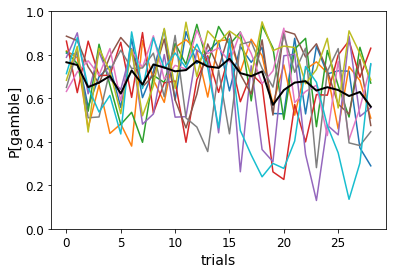

In [17]:
for ep in range(0,10):
    plt.plot(prob_test[ep,:])
plt.plot(prob_test_df.mean(),linewidth=2,color="black"); 
plt.ylim([0,1])
plt.xlabel('trials')
plt.ylabel('P[gamble]')